In [1]:
from my_model import *
from my_data import *
import random

In [2]:
data = prepare_training_data("berlin_extracted_train",
network_pattern_mid="network_berlin", ls_pattern_mid=".linkstats_berlin")  
print(data)
ds = build_dataset(data)

[(GraphTensor(
  context=Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['links'],
  edge_set_names=['line_graph']), <tf.Tensor: shape=(27664, 25), dtype=float32, numpy=
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 31.],
       [ 0.,  0.,  0., ...,  0.,  1., 19.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1., 10.],
       [ 0.,  0.,  0., ...,  0.,  0.,  6.],
       [ 0.,  0.,  0., ...,  0.,  0.,  6.]], dtype=float32)>), (GraphTensor(
  context=Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['links'],
  edge_set_names=['line_graph']), <tf.Tensor: shape=(27664, 25), dtype=float32, numpy=
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 30.],
       [ 0.,  0.,  0., ...,  0.,  1., 17.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  9.],
       [ 0.,  0.,  0., ...,  0.,  0.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  5.]], dtype=float32)>

In [3]:
data_val = prepare_training_data("berlin_extracted_val",
network_pattern_mid="network_berlin", ls_pattern_mid=".linkstats_berlin")  
print(data)
ds_val = build_dataset(data)

[(GraphTensor(
  context=Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['links'],
  edge_set_names=['line_graph']), <tf.Tensor: shape=(27664, 25), dtype=float32, numpy=
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 31.],
       [ 0.,  0.,  0., ...,  0.,  1., 19.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1., 10.],
       [ 0.,  0.,  0., ...,  0.,  0.,  6.],
       [ 0.,  0.,  0., ...,  0.,  0.,  6.]], dtype=float32)>), (GraphTensor(
  context=Context(features={}, sizes=[1], shape=(), indices_dtype=tf.int32),
  node_set_names=['links'],
  edge_set_names=['line_graph']), <tf.Tensor: shape=(27664, 25), dtype=float32, numpy=
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 30.],
       [ 0.,  0.,  0., ...,  0.,  1., 17.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  9.],
       [ 0.,  0.,  0., ...,  0.,  0.,  5.],
       [ 0.,  0.,  0., ...,  0.,  0.,  5.]], dtype=float32)>

In [6]:
train_dataset = ds
batch_size = 32
train_ds_batched = train_dataset.shuffle(buffer_size=3).batch(batch_size=batch_size).repeat()

In [74]:
# Build model
model2 = build_regression_model(
    graph_tensor_spec=model_input_graph_spec,
    node_dim=128,
    edge_dim=32,
    message_dim=128,
    next_state_dim=128,
    output_dim=25,  # Regression outputs fA, fB, fC
    num_message_passing=3,
    l2_regularization=0,
    dropout_rate=0, )

# Compile model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Print model structure
model2.summary()

f =  KerasTensor(type_spec=TensorSpec(shape=(27664, 33), dtype=tf.float32, name=None), name='tf.concat_2/concat:0', description="created by layer 'tf.concat_2'")
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [()]                      0         
                                                                 
 input.merge_batch_to_compo  ()                        0         
 nents_2 (InstanceMethod)                                        
                                                                 
 map_features_2 (MapFeature  ()                        37440     
 s)                                                              
                                                                 
 graph_update_6 (GraphUpdat  ()                        65792     
 e)                                                              
                             

In [75]:
# Train model
history2 = model2.fit(train_ds_batched, steps_per_epoch=10,epochs=150,validation_data=ds_val)

Epoch 1/150


10/10 [==============================] - 102s 10s/step - loss: 30216355840.0000 - mean_absolute_error: 81517.7656 - root_mean_squared_error: 173828.5156 - val_loss: 489736800.0000 - val_mean_absolute_error: 17341.2031 - val_root_mean_squared_error: 22130.0020
Epoch 2/150
10/10 [==============================] - 99s 10s/step - loss: 232670832.0000 - mean_absolute_error: 11143.4639 - root_mean_squared_error: 15253.5518 - val_loss: 91685400.0000 - val_mean_absolute_error: 6884.1885 - val_root_mean_squared_error: 9575.2480
Epoch 3/150
10/10 [==============================] - 99s 10s/step - loss: 54200692.0000 - mean_absolute_error: 5420.6094 - root_mean_squared_error: 7362.1113 - val_loss: 29874510.0000 - val_mean_absolute_error: 4203.8457 - val_root_mean_squared_error: 5465.7583
Epoch 4/150
10/10 [==============================] - 96s 10s/step - loss: 22773358.0000 - mean_absolute_error: 3564.2209 - root_mean_squared_error: 4772.1436 - val_loss: 16111813.0000 - val_mean_absolute_error: 29

In [354]:
val_ds = ds.take(10)
predict_graphs = []
actual_labels = []

# Generate prediction
for graph, labels in val_ds:
    predict_graph = model2(graph)  # Prediction
    predict_graphs.append(predict_graph.numpy())  # Save prediction results
    actual_labels.append([labels.numpy()])  # Save actual labels

# Convert to NumPy array
predict_graphs = np.concatenate(predict_graphs, axis=0)
actual_labels = np.concatenate(actual_labels, axis=0)

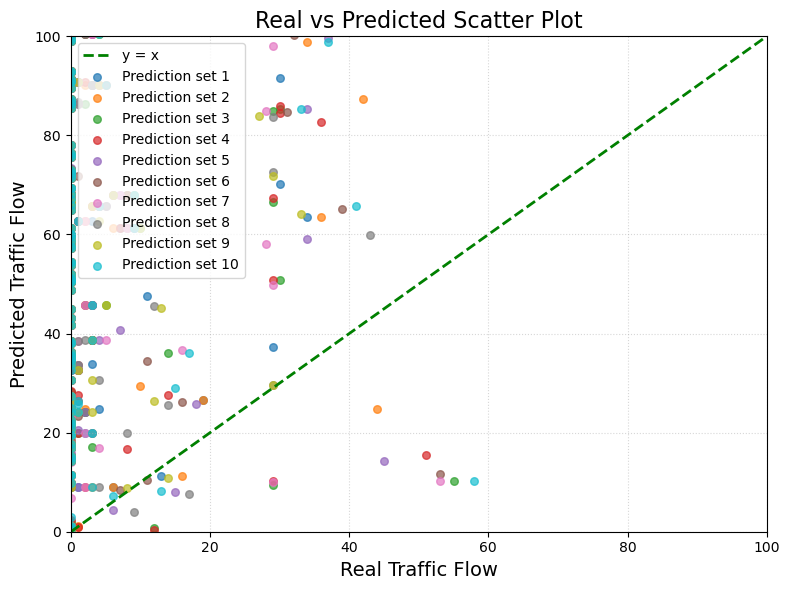

In [ ]:
fig = plt.figure(figsize=(8, 6))  

  
plt.plot([0, 100], [0, 100],  
         linestyle='--',          
         color='green',  
         linewidth=2,  
         label='y = x')  
index_i = random.sample(range(0, len(predict_graphs[0])), 15)

for j in range(len(predict_graphs)):  
    x = actual_labels[j][index_i]  
    y = predict_graphs[j][index_i]    
    plt.scatter(  
        x, y,  
        c='C{}'.format(j),      
        s=30,  
        alpha=0.7,  
        label=f'Prediction set {j+1}'  
    )  

plt.xlabel('Real Traffic Flow', fontsize=14)  
plt.ylabel('Predicted Traffic Flow', fontsize=14)  
plt.title('Real vs Predicted Scatter Plot', fontsize=16)  
plt.grid(True, linestyle=':', alpha=0.5)  
plt.legend(loc='upper left')      
plt.xlim(0, 100)  
plt.ylim(0, 100)  

plt.tight_layout()  
plt.show()

In [109]:
tf.saved_model.save(model2, "my_saved_model_berlin_2") 
import json  

with open("train_history_berlin_2.json", "w") as f:  
    json.dump(history2.history, f)

c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
c:\Users\ke\AppData\Local\anaconda3\envs\tfgnn\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this StructuredValue will require that this type be impor

INFO:tensorflow:Assets written to: my_saved_model_berlin_2\assets


INFO:tensorflow:Assets written to: my_saved_model_berlin_2\assets


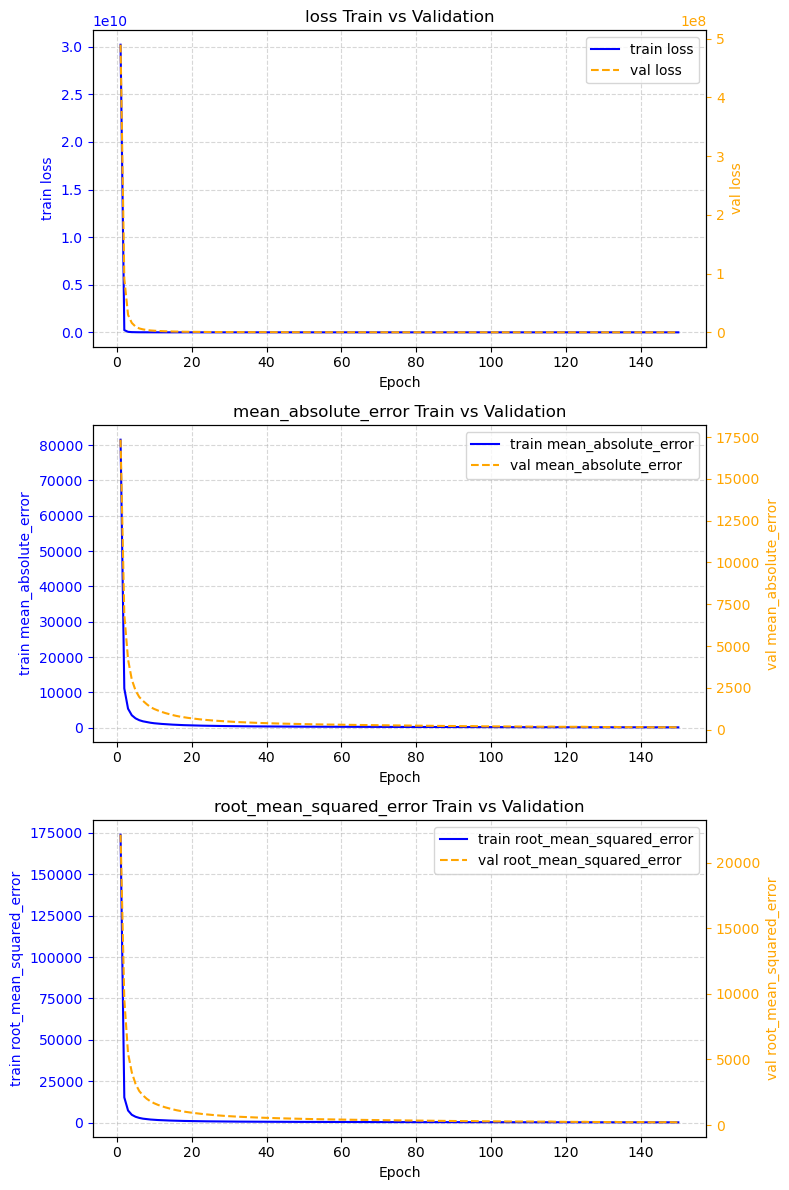

In [118]:
metrics = [m for m in history2.history if not m.startswith("val_")]  
n = len(metrics)  

fig, axes = plt.subplots(n, 1, figsize=(8, 4 * n), squeeze=False)  
for i, metric in enumerate(metrics):  
    val_metric = f"val_{metric}"  
    if val_metric not in history2.history:  
        continue  

    epochs = range(1, len(history2.history[metric]) + 1)  
    ax1 = axes[i, 0]  
    ax2 = ax1.twinx()  

    # train  
    ax1.plot(epochs, history2.history[metric],  
             color='blue', label=f"train {metric}")  
    ax1.set_ylabel(f"train {metric}", color='blue')  
    ax1.tick_params(axis='y', colors='blue')  

    # val  
    ax2.plot(epochs, history2.history[val_metric],  
             color='orange',  label=f"val {metric}",linestyle="--")  
    ax2.set_ylabel(f"val {metric}", color='orange')  
    ax2.tick_params(axis='y', colors='orange')  

     
    ax1.set_xlabel("Epoch")  
    ax1.grid(True, linestyle="--", alpha=0.5)  
    lines = ax1.get_lines() + ax2.get_lines()  
    labels = [l.get_label() for l in lines]  
    ax1.legend(lines, labels, loc="best")  
    ax1.set_title(f"{metric} Train vs Validation")  

plt.tight_layout()  
plt.show()

In [384]:
dls = []
for dg in data:
    dls.append(np.array(dg[1][:,-1]).flatten())
dls_val = []
for dg in data_val:
    dls_val.append(np.array(dg[1][:,-1]).flatten())
print(len(dls))
print(len(dls_val))

240
60


In [385]:
array_dl = np.array(dls).flatten()
array_dl_val = np.array(dls_val).flatten()
print(len(array_dl))
print(len(array_dl_val))

6639360
1659840


In [386]:
print(np.max(array_dl))
print(np.max(array_dl_val))

482.0
468.0


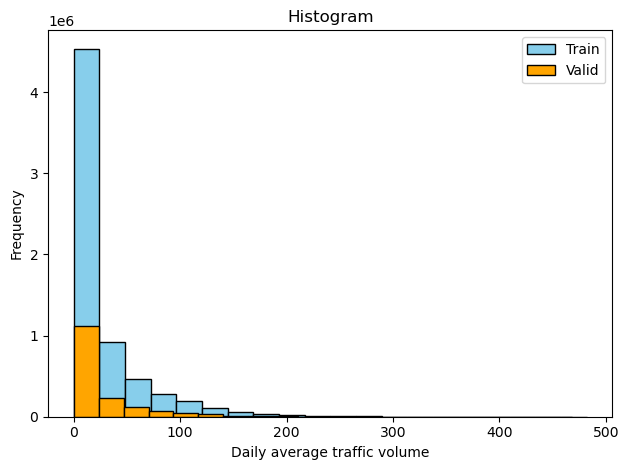

In [391]:
plt.hist(array_dl, bins=20, color='skyblue', edgecolor='black',label='Train')
plt.hist(array_dl_val, bins=20, color='orange', edgecolor='black',label='Valid')   
plt.legend()
plt.title('Histogram')  
plt.xlabel('Daily average traffic volume')  
plt.ylabel('Frequency')  

plt.tight_layout()    
plt.show()  